# Domain Risk Training and Evaluation

This notebook trains the domain risk model and evaluates PR/confusion metrics.

In [1]:
from pathlib import Path
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split

from sentineldns.features.domain_features import build_domain_feature_matrix
from sentineldns.models.domain_risk import train_domain_risk_model
from sentineldns.models.export import export_joblib, export_metadata

csv_path = Path('../data/processed/labeled_domains.csv')
artifacts_dir = Path('../data/artifacts/domain_risk')
df = pd.read_csv(csv_path)
print('rows:', len(df))
print(df['label'].value_counts())
print(df.groupby('label')['domain'].nunique())
df.head()

rows: 102587
label
0    99990
1     2597
Name: count, dtype: int64
label
0    99990
1     2597
Name: domain, dtype: int64


,domain,label,source,raw_value
0,000cheapdomains.com,0,tranco,000cheapdomains.com
1,000webhost.com,0,tranco,000webhost.com
2,000webhostapp.com,0,tranco,000webhostapp.com
3,003ms.ru,0,tranco,003ms.ru
4,007.com,0,tranco,007.com


{'threshold': np.float64(0.9999996930372802), 'precision': np.float64(1.0), 'recall': np.float64(0.0015408320493066256)}


/var/folders/pb/90kprmwx0px0ldn0h4hbt2m80000gn/T/ipykernel_9736/1275824533.py:43: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  'model_version': pd.Timestamp.utcnow().strftime('%Y%m%dT%H%M%SZ'),


{'model_version': '20260217T203807Z',
 'train_rows': 76940,
 'test_rows': 25647,
 'threshold': 0.55,
 'target_fpr': 0.01,
 'known_benign_exact_count': 8,
 'scalar_feature_names': ['length',
  'num_labels',
  'tld_hash',
  'digit_ratio',
  'hyphen_count',
  'vowel_ratio',
  'entropy',
  'punycode_flag',
  'has_suspicious_words',
  'brand_edit_distance_min'],
 'precision_curve_points': 25648,
 'recall_curve_points': 25648,
 'confusion_matrix': [[24952, 46], [100, 549]]}

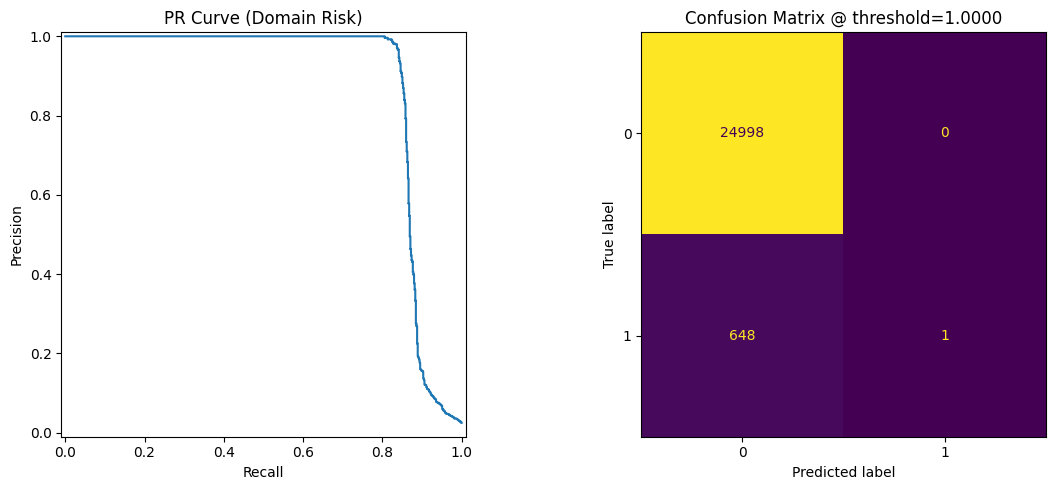

In [2]:
domains = df['domain'].astype(str).tolist()
y = df['label'].astype(int).to_numpy()

X, vectorizer, _ = build_domain_feature_matrix(domains)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=500, random_state=42)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probs)

fpr, _, thresholds = roc_curve(y_test, probs)
finite = [(fp, thr) for fp, thr in zip(fpr, thresholds, strict=True) if np.isfinite(thr)]
candidates = [thr for fp, thr in finite if fp <= 0.01]
threshold = max(candidates) if candidates else 0.9
pred = (probs >= threshold).astype(int)

cm = confusion_matrix(y_test, pred)
tp = cm[1, 1]
fp_count = cm[0, 1]
fn = cm[1, 0]
precision_at_threshold = tp / max(tp + fp_count, 1)
recall_at_threshold = tp / max(tp + fn, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=axes[0])
axes[0].set_title('PR Curve (Domain Risk)')
ConfusionMatrixDisplay(cm).plot(ax=axes[1], colorbar=False)
axes[1].set_title(f'Confusion Matrix @ threshold={threshold:.4f}')
plt.tight_layout()

print({'threshold': threshold, 'precision': precision_at_threshold, 'recall': recall_at_threshold})

artifacts_dir.mkdir(parents=True, exist_ok=True)
export_joblib(artifacts_dir / 'model.joblib', model)
export_joblib(artifacts_dir / 'vectorizer.joblib', vectorizer)
export_metadata(
    artifacts_dir / 'metadata.json',
    {
        'model_version': pd.Timestamp.utcnow().strftime('%Y%m%dT%H%M%SZ'),
        'train_rows': int(len(y_train)),
        'test_rows': int(len(y_test)),
        'threshold': float(threshold),
        'target_fpr': 0.01,
    },
)

# Also run package training path for parity with CLI/service behavior.
metrics = train_domain_risk_model(csv_path)
metrics

In [3]:
# False-positive / true-positive analysis
# Rebuild the exact test split indices so we can inspect domain-level outcomes.
index_df = df.reset_index().rename(columns={'index': 'row_id'})
idx = index_df['row_id'].to_numpy()
_, idx_test, _, _ = train_test_split(idx, y, test_size=0.25, random_state=42, stratify=y)
analysis_df = df.iloc[idx_test].copy().reset_index(drop=True)
analysis_df['prob'] = probs
analysis_df['pred'] = pred

false_positives = analysis_df[(analysis_df['label'] == 0) & (analysis_df['pred'] == 1)].sort_values('prob', ascending=False)
true_positives = analysis_df[(analysis_df['label'] == 1) & (analysis_df['pred'] == 1)].sort_values('prob', ascending=False)

print('Top false positives')
display(false_positives[['domain', 'prob', 'source']].head(20))
print('Top true positives')
display(true_positives[['domain', 'prob', 'source']].head(20))

Top false positives


,domain,prob,source


Top true positives


,domain,prob,source
2224,f3i5-0g49bgn-3h95-1324992141.cos.ap-jakarta.my...,1.0,urlhaus_or_phishtank
